In [ ]:
!pip install -U sentence-transformers

### Libraries 

In [2]:
import os 
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import nltk
import spacy
import gensim
import pyLDAvis
import dask.bag as bd 
import networkx as nx
import re, unicodedata
import dask.dataframe as ddf
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis

from dask import delayed
from dask import compute
from scipy import spatial
from pprint import pprint
from itertools import chain
from nltk.stem.porter import *
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pyvis.network import Network
from prettytable import PrettyTable
from nltk.tokenize import TweetTokenizer
from gensim.models import CoherenceModel
from networkx.algorithms import community
from rpy2.robjects.packages import importr
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

warnings.filterwarnings('ignore', 'SelectableGroups dict interface')

C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:23: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  serialized_pb=_b('\n,tensorflow/core/framework/tensor_shape.proto\x12\ntensorflow\"z\n\x10TensorShapeProto\x12-\n\x03\x64im\x18\x02 \x03(\x0b\x32 .tensorflow.TensorShapeProto.Dim\x12\x14\n\x0cunknown_rank\x18\x03 \x01(\x08\x1a!\n\x03\x44im\x12\x0c\n\x04size\x18\x01 \x01(\x03\x12\x0c\n\x04name\x18

C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,


In [3]:
os.chdir('input_path')

### Default values

In [4]:
col_name = 'col_name'
project_name = 'project_name_'
dataset_name = 'file_name.format'

### Load Dataset

In [5]:
df = pd.read_excel(dataset_name,engine ='openpyxl')

nRow, nCol = df.shape
df = df.set_index('Response ID')
print(f'There are {nRow} rows and {nCol} columns')

There are 3000 rows and 355 columns


### Preprocessing
#### Stopword list

In [6]:
stop_words_add = pd.read_excel('stopword.xlsx',engine='openpyxl')
stop_words_add = list(stop_words_add['V1'])
stop_words = list(stopwords.words("spanish"))
stop_words = stop_words_add + stop_words 
stop_words = list(dict.fromkeys(stop_words))

#### Preprocessing pipeline

In [7]:
nlp = spacy.load('es_core_news_lg')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def tokenizador(text):
    return(' '.join(tknzr.tokenize(text)))

def sent_to_words(sentence):
    return(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len = 4))

def remove_stopwords(doc):
    return ' '.join([word.strip() for word in simple_preprocess(str(doc)) 
   if word.strip() not in stop_words])

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','INTJ']): 
    doc = nlp(text)
    return  [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def clean_text(df, variable = 'ABIERTA CON ORTOGRAFÍA'):
    data_lemmatized = df[variable][~df[variable].isna()].map(tokenizador).map(sent_to_words).map(remove_stopwords).map(lemmatization)
    
    filtro = data_lemmatized.map(len) > 0 
    data_lemmatized = data_lemmatized[filtro]
    
    return data_lemmatized

In [8]:
%%time

data_lemmatized = clean_text(df,variable = col_name)

Wall time: 10.7 s


### EDA

In [9]:
words = list(chain.from_iterable(data_lemmatized))
pt = PrettyTable(field_names=['Palabra', 'Conteo']) 

c = Counter(words)
[ pt.add_row(kv) for kv in c.most_common()[:10] ]
pt.align['Palabra'], pt.align['Conteo'] = 'l', 'r' 
pt._max_width = {'Palabra':60, 'Conteo':10}
print(pt)

+-------------+--------+
| Palabra     | Conteo |
+-------------+--------+
| bueno       |    373 |
| mejor       |    253 |
| plan        |    186 |
| promocionar |    162 |
| servicio    |    146 |
| cobertura   |    145 |
| celular     |    140 |
| descontar   |    121 |
| descuento   |    116 |
| precio      |    106 |
+-------------+--------+


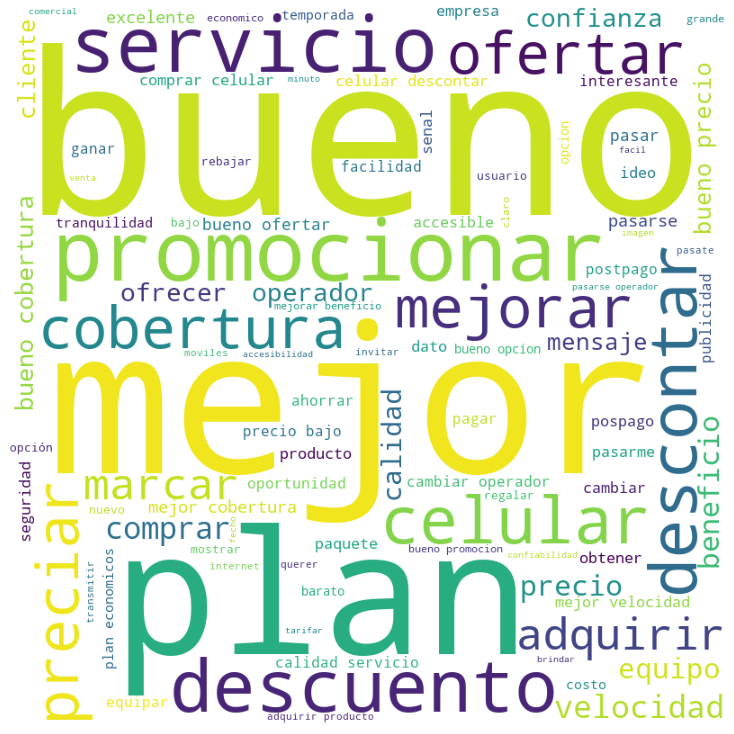

In [10]:
str_words = ' '.join(words) 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(str_words)
                    
plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

### Embedding 
#### Unigram analysis - Glove

In [11]:
%%time
unique_words = list(set([word for sublist in [' '.join(doc).split() for doc in data_lemmatized] for word in sublist]))

word_vectors = np.array([nlp(word).vector for word in unique_words])
df = pd.DataFrame(word_vectors, index=unique_words)
filtro = df.apply(np.sum, axis=1) == 0
df = df[-filtro]

sum(filtro)

Wall time: 3.33 s


67

#### Unigram analysis - BERT

In [ ]:
%%time

model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')
word_vectors = np.array([model.encode(word) for word in unique_words])
df = pd.DataFrame(word_vectors, index=unique_words)
filtro = df.apply(np.sum, axis=1) == 0
df = df[-filtro]

sum(filtro)

The available options for embedding are unlimited for more pre-trained models we could take a look [here](https://huggingface.co/models?pipeline_tag=sentence-similarity)

#### Network analysis

In [12]:
vocabulario = list(df.index)

from_ = []
to_ = []

for i in range(len(vocabulario)-1):
    from_i = list(np.repeat([vocabulario[i]],len(vocabulario[i+1:]), axis=0))
    from_.extend(from_i)
    to_.extend(vocabulario[i+1:])
    
print('Número de enlaces:',len(from_))

Número de enlaces: 211575


In [13]:
def similitude(tuple_,cutoff=0.5):
    
    dictionary = [ ]     
    for de, a in tuple_:
        simil = 1 - spatial.distance.cosine(np.array(df.loc[de,:]),np.array(df.loc[a,:]))
        if simil > cutoff:
            dictionary.append(dict(from_= de, to_ =a, sim = simil))

    return dictionary

In [14]:
%%time
tuple_bd = bd.from_sequence(list(zip(from_,to_)),npartitions=10) 
dictionary = tuple_bd.map_partitions(similitude,cutoff=0.5)
dictionary.take(5)

Wall time: 6.46 s


({'from_': 'grande', 'to_': 'mayor', 'sim': 0.5240121483802795},
 {'from_': 'grande', 'to_': 'prominente', 'sim': 0.50672847032547},
 {'from_': 'grande', 'to_': 'importante', 'sim': 0.5397033095359802},
 {'from_': 'grande', 'to_': 'alto', 'sim': 0.5223084688186646},
 {'from_': 'grande', 'to_': 'grandioso', 'sim': 0.6182151436805725})

In [15]:
%%time
word_corr = dictionary.to_dataframe()
word_corr.head()

Wall time: 8.43 s


,from_,to_,sim
0,grande,mayor,0.524012
1,grande,prominente,0.506728
2,grande,importante,0.539703
3,grande,alto,0.522308
4,grande,grandioso,0.618215


In [16]:
%%time
grafo = word_corr.compute()
grafo = grafo.rename(columns={"from_": "from", "to_": "to"})

print('network size:', len(grafo))

network size: 17383
Wall time: 36.8 s


In [17]:
nodos = list(grafo['from'])
nodos.extend(grafo['to'])
nodos = set(nodos)
words = [word for word in list(chain.from_iterable(data_lemmatized)) if word in nodos]
c = Counter(words)

diam = pd.DataFrame.from_dict(c, orient='index')\
                   .reset_index().rename(columns = {'index' : 'word', 0: 'size'}).sort_values('word')

print('Network order:', len(nodos))

Network order: 602


In [18]:
%%time

#* Edges 
filtro = grafo.sim > 0.6
network = grafo.loc[filtro,:]
network = network.rename(columns = {'sim':'weight'})#/sum(network['sim'])
G = nx.from_pandas_edgelist(network, 'from','to',edge_attr  = 'weight')

#* Node diameter
for node, size in list(zip(diam['word'],diam['size'])):
    if (node in list(network['from'])) or (node in list(network['to'])):
        G.add_node(node, size = size)       
        
diam_export = pd.DataFrame(index=G.nodes())
diam_export['size'] = pd.Series(nx.get_node_attributes(G, 'size'))    
    
#* Frequency
min_freq = 8 
elim_nodes = []
for node, size in list(G.nodes(data=True)):
    if len(size) == 0:
        elim_nodes.append(node) 
    elif size['size'] < min_freq:   
        elim_nodes.append(node) 
        
G.remove_nodes_from(elim_nodes) 
        
#* Components
min_len = 5
componentes = nx.connected_components(G)
[elim_nodes.extend(comp) for comp in componentes if len(comp) < min_len] 
                
G.remove_nodes_from(elim_nodes)   

#* Width 
width = np.array([w for i,j, w in list(G.edges(data='weight'))])
width =  np.interp(width, (width.min(), width.max()), (+1, +5))

for e, w in list(zip(list(G.edges()),width)):
    G.add_edge(e[0],e[1],width = w)

#* Cluster 
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G,weight ='weight') #SBM 
i = 1 
for community in communities:
    for node in community:
        G.add_node(node, group = i)
    i = i + 1
    
#* Rescale node size
sizes = np.array([ node_info['size'] for node, node_info in list(G.nodes(data=True))])
sizes = np.interp(sizes, (sizes.min(), sizes.max()), (+min_freq, +50))

for size, node in zip(sizes,list(G.nodes())):
    G.nodes(data=True)[node]['size'] = size
    
print('Order:', len(G.nodes()))
print('Size:', len(G.edges()))    
print('Transitivity:',nx.transitivity(G))
print('Clusters:',i)

Order: 45
Size: 112
Transitivity: 0.48400556328233657
Clusters: 6
Wall time: 340 ms


**Saving files**

In [ ]:
os.chdir('../input_path')
grafo.to_excel('grafo-'+ +'.xlsx',index = False)
diam_export.to_excel('diam-'+ +'.xlsx')

**Network display**

In [ ]:
net = Network(height='800px',width = '800px')
net.show_buttons()

net.from_nx(G)
os.chdir('../output_path')
net.show(project_name + col_name +'.html')